# Properties and error estimation of reduced-order spline interpolation

In [2]:
# Import necessary modules
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Set plot font and size
#font = {'family':'Times New Roman', 'size':14}
font = {'size': 14}
plt.rc('font', **font)

# Uncomment next three lines if romSpline is not in your PYTHONPATH
# import sys
# sys.path.append(<path to your copy of romspline>)
import sys
sys.path.append("..")
import romspline

As in the "romSpline_example.ipynb" notebook we will consider the test data
that comes with `romSpline`. The default options output arrays with 4001 elements.

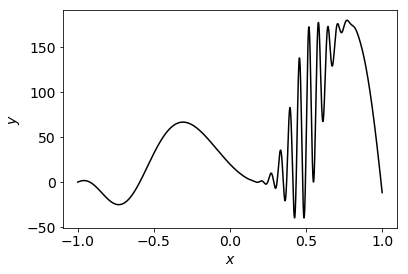

In [3]:
test = romspline.TestData()  # Default is to output at 4001 uniformly spaced samples
plt.plot(test.x, test.y, 'k-');
plt.xlabel('$x$');
plt.ylabel('$y$');

And let's build a reduced-order spline for this data set using the default parameters, `tol`=1e-6 and `deg`=5.

In [4]:
spline = romspline.ReducedOrderSpline(test.x, test.y)
print("Size of reduced data =", spline.size)
print("Compression factor =", spline.compression)

Size of reduced data = 441
Compression factor = 9.072562358276643


See the accompanying notebook "romSpline_example.ipynb" for more information
about building a reduced-order spline with `romSpline`.

## Convergence studies

Let's decimate the original data array by powers of 2 and
use the resulting data to build a reduced-order spline. Convergence will be
attained (at the same tolerance and polynomial degree) if 
the sizes of the reduced data converge. Here, the option `levs` indicates
the factor that we wish to decimate the data by. For example, a `lev` of 8
indicates that we will take every 8th data point in the set.

In [5]:
conv = romspline.Convergence()
conv.make(test.x, test.y, levs=[32, 16, 8, 4, 2, 1])

# Default values:
#  spline = None  (You can input the full spline with this option 
#                  without recomputing it, if desired)
#  levs = [8, 4, 2]
#  tol = 1e-6
#  rel = False
#  deg = 5

Plot the maximum spline errors for each decimated training set. 
Notice that several curves overlap at an error of 1e-6, sugggesting that the 
reduced-order spline is convergent for a tolerance of 1e-6.

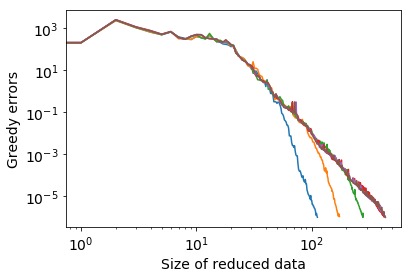

In [6]:
conv.plot_greedy_errors(axes='loglog')

However, perhaps a better view of convergence is provided by plotting the final sizes 
of the reduced data for each of the decimated data sets. A meaningfully
notion of convergence is when the sizes of these reduced data sets
are nearly constant or not increasing, at least. In this sense of convergence,
the plot below shows that we are in a convergent regime, in fact, after 
a decimation by a factor of 2, maybe 4.

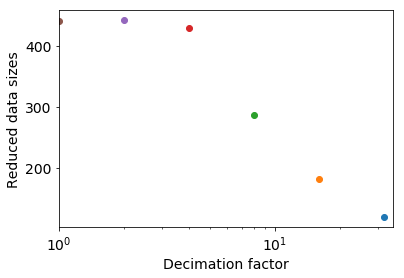

In [7]:
conv.plot_sizes()

From the two plots above we see that the reduced-data sizes are 
not changing much as we approach the case of using all the available data to build
the reduced-order spline (i.e., a decimation factor of $10^0$). By this measure, the greedy algorithm
has converged. Furthermore, we see that the maximum spline errors
seem to level off, which can also be used as a way to assess convergence.

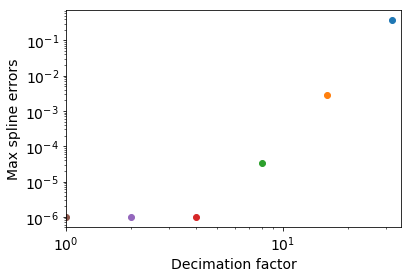

In [8]:
conv.plot_Linfty_errors()

Convergence depends on both the requested tolerance for the spline 
and how finely the full dataset is sampled. For example, the test data
is sampled sufficiently finely to achieve convergence for a tolerance
of $10^{-6}$. However, if the tolerance is lowered to $10^{-12}$ then
(everything else being the same) convergence is not reached. The next 
block of code shows how the reduced-order spline is not convergent
for `tol`=1e-12.

/Users/cgalley/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3099: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  self.set_xlim(upper, lower, auto=None)


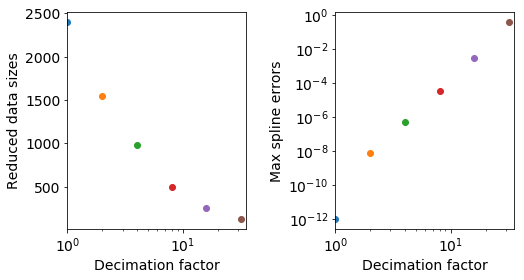

In [9]:
# Build a reduced-order spline with tol=1e-12
conv2 = romspline.Convergence(tol=1e-12)
conv2.make(test.x, test.y, levs=[1, 2, 4, 8, 16, 32])

# Plot the sizes and max spline errors
# This block of code also shows how to use some of the
# more advanced plotting features. See the documentation
# for more details.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[8,4])
plt.subplots_adjust(wspace=0.5)
conv2.plot_sizes(ax=ax[0], show=False)
conv2.plot_Linfty_errors(ax=ax[1], show=False)
ax[1].set_yticks([1e-12, 1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1e0]);

## Random seeds

One can generate reduced-order splines using randomly generated seeds for the greedy
algorithm instead of the default equally spaced ones.

In [9]:
spline_new_seed = romspline.ReducedOrderSpline(test.x, test.y, seeds=[0, 1, 2, 3, 4, 5])

print("Size of reduced-data with default seed =", spline.size)
print("Size of reduced-data with new seed =", spline_new_seed.size)

Size of reduced-data with default seed = 441
Size of reduced-data with new seed = 448


One can carry this further and look at how the size of reduced-data sets
depend on the points used to seed the greedy algorithm. This serves two purposes.
The first indicates how robust the size of the reduced data is to changes
in the initial seed values. The second is to maximize the amount of 
data compression by selecting the reduced-order spline that has the smallest
such size for the set of sampled seeds. Note that all of the splines that are so 
generated represent the original data set to within the requested tolerance, 
by construction.

In [10]:
# NOTE: This may take a few minutes for a large number of seeds.
# NOTE: RandomSeeds doesn't quantify the error of the reduced-order spline since all
#       the splines generated here meet the default 1e-6 tolerance. However, it gives
#       an idea of how robust the reduced data sizes found by the greedy 
#       algorithm are to initial seed choices.
seeds = romspline.RandomSeeds(tol=1e-6, deg=5)
seeds.make(test.x, test.y, 1000, parallel=True)  # Default option for parallel is True

Plot the distribution of the number of selected points (i.e., sizes) along with their
mean (solid black) and standard deviation (dashed black). The red curve is
the number of points that our original spline contains.

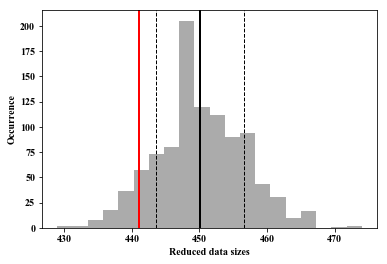

In [11]:
ax = seeds.plot_sizes(show=False);
ax.axvline(x=spline.size, color='r', linewidth=2);
ax.set_xlabel('Reduced data sizes');
ax.set_ylabel('Occurrence');

Notice that in sampling the space of possible seeds we will encounter a smallest spline. 

In [20]:
print("Smallest size of reduced-data set encountered =", int(min(seeds.sizes)))
print("Seed points that gave smallest size =", test.x[[int(ss) for ss in seeds.seeds[np.argmin(seeds.sizes)]]])

Smallest size of reduced-data set encountered = 429
Seed points that gave smallest size = [-0.945  -0.829  -0.51   -0.3485 -0.2835  0.766 ]


We can use the function `small_spline` to output the smallest reduced-order spline interpolant and reduced data set that is encountered in randomly sampling the seeds. The function even allows you to sample in the polynomial degree to ensure that you are getting the smallest spline realized.

Here's an example usage. We don't fix the polynomial degree so `small_spline` will also sample integer degrees in [1,5]. And we'll specify that 20 random seed sets be used to find the smallest reduced data size. Keep in mind that more random seed sets will take longer to determine the smallest spline realized but will also be more thorough in its exploration of the parameter space. If you just want to find the smallest encountered spline for a specific degree(s) then set the `deg` option keyword to the desired integer(s) in [1,5].

In [21]:
small_spline = romspline.small_spline(test.x, test.y, 20, verbose=True)

Smallest spline for degree 1 is...
3994
Smallest spline for degree 2 is...
2281
Smallest spline for degree 3 is...
1499
Smallest spline for degree 4 is...
669
Smallest spline for degree 5 is...
446


The size, polynomial degree, and seed of the smallest spline encountered is:

In [22]:
print("Smallest size =", small_spline.size)
print("Degree        =", small_spline._deg)
print("Seed          =", small_spline._seed)

Smallest size = 446
Degree        = 5
Seed          = [ 933.  981. 2293. 2409. 2990. 3244.]


Compare the size of the smallest spline to the spline we built at the beginning of this notebook with the default seed choice, which has a size of 441. See the `small_spline` documentation for further details.

## Cross-validation to estimate interpolation error

When we have "real-life" data, one usually cannot upsample it to directly assess the 
interpolation errors. Instead, we can use cross-validation methods to provide error estimates using only the available data.

### Leave-one-out cross-validation

A leave-one-out cross-validation study chooses the first data point and reserves 
it for validation. This reserved set (which contains one point) is sometimes called a validation partition or subset. 
A reduced-order spline is built using the remaining points (sometimes called a 
training partition or subset)
and the absolute error is computed for the spline's prediction at the validation
point. This is repeated until every point in the original data set has been 
used for validation. This results in one validation error for each data point.
These errors provide an estimate for the upper bound on the interpolation error.

Leave-one-out studies can be performed using the `LeaveOneOut` method, which is 
shown below.

In [23]:
# Create a CrossValidation object. Optional arguments include 
# tol (default 1e-6) and deg (default 5)
cv = romspline.CrossValidation(tol=1e-6, deg=5)

# NOTE: This will take several minutes since 4001 trial
#       reduced-order splines will be built. 
cv.LeaveOneOut(test.x, test.y, parallel=True)

The plot below shows the validation errors for each sample from the leave-one-out study.
Most errors are below the requested tolerance of 1e-6 and thus don't contain any
additional information that is different from the tolerance. The relevant errors are the ones
greater than or equal to the tolerance. The red and blue lines show the mean and median,
respectively, of those validation errors greater than or equal to the tolerance, 1e-6. 

All validation errors can be accessed with the `errors` attribute while those errors greater than or equal to the reduced-order spline tolerance are contained in the `errors_ge_tol` attribute. Other attributes exist containing information about the array indexes of the samples where the validation errors are calculated (e.g., `args` and `args_ge_tol`).

Mean of validation errors >= tol is 1.2091028282201766e-06
Median of validation errors >= tol is 1.1764011453863077e-06


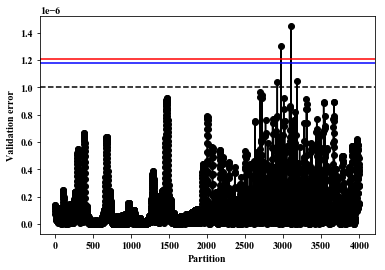

In [24]:
ax = cv.plot_partition_errors(show=False)
ax.axhline(y=cv._tol, linestyle='--', color='k');  # Requested spline tolerance
ax.axhline(y=np.mean(cv.errors_ge_tol), color='r');   # Mean validation error
ax.axhline(y=np.median(cv.errors_ge_tol), color='b'); # Median validation error

print("Mean of validation errors >= tol is", np.mean(cv.errors_ge_tol))
print("Median of validation errors >= tol is", np.median(cv.errors_ge_tol))

For relatively large datasets, leave-one-out cross-validation studies can
be computationally expensive. An alternative is to use the K-fold cross-validation method.
K-fold cross-validation is a useful tool from the field of statistical learning 
that we can use to provide an estimate for the error that the reduced-order 
spline will make in predicting values at new data samples through interpolation.

K-fold cross-validation proceeds by taking K subsets of the full dataset where
the K subsets contain randomly selected points from the data. The union of these
subsets is just the data set itself (though unordered because of the random filling 
of the subsets).
The first subset, or partition, (called the validation partition) is reserved while a reduced-order
spline interpolant is built using the other K-1 partitions (which comprise a 
trial training set). The maximum absolute error between the resulting trial spline and
points in the validation partition is computed and recorded. These steps are repeated
for all the other partitions so that each of the K subsets has been used once
for validation. This results in K validation errors. 

Here, we use K=10 partitions so that 10% of the data is reserved for validation at any step.
(K=10 is the default value in the code.)

In [25]:
cv2 = romspline.CrossValidation()
cv2.Kfold(test.x, test.y, K=10)

We plot the error for each of the K=10 subsets (or partitions) below. The black dashed line 
shows the requested tolerance of 1e-6. Notice that those validation errors
below the tolerance line are not terribly meaningful since the full reduced-order
spline we built earlier (which we called `spline` above) is guaranteed to 
represent that data with an error better than 1e-6. The validation errors above
the tolerance are, in some sense, the most meaningful ones. So we show the
mean (red) and median (blue) of those errors greater than the tolerance.

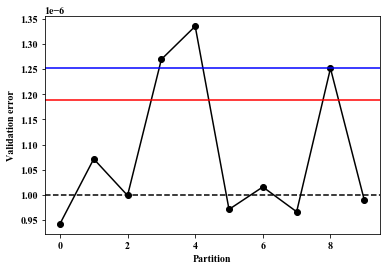

In [26]:
# ...and plot the validation errors
ax = cv2.plot_partition_errors(show=False) # show=False means don't show the plot 
                                           # but instead output the matplotlib plot object
                                           # so that we can add extra things to the plot
ax.axhline(y=cv2._tol, linestyle='--', color='k');  # Requested spline tolerance

# Mean validation error for errors greater than 1e-6
ax.axhline(y=np.mean(cv2.errors_ge_tol), color='r');

# Median validation error for errors greater than 1e-6
ax.axhline(y=np.median(cv2.errors_ge_tol), color='b');

Let's see how the cross-validation errors depend on the number of subsets, K.

In [27]:
cv3 = romspline.CrossValidation()

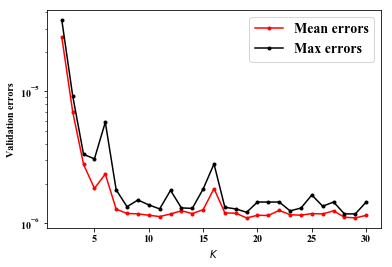

In [28]:
means = []
maxs = []
K = np.arange(2, 31)  # Different number of subsets, K
for kk in K:
    cv3.Kfold(test.x, test.y, K=kk)
    means.append( np.mean(cv3.errors_ge_tol) )
    maxs.append( np.max(cv3.errors) )

plt.semilogy(K, means, 'r.-', label='Mean errors')
plt.semilogy(K, maxs, 'k.-', label='Max errors')
plt.legend(loc='upper right', prop={'size':14});
plt.xlabel('$K$')
plt.ylabel('Validation errors');

We see that after K=10 or 15 that the mean validation errors have converged to 
a constant that is roughly independent of the number of subsets K used in the 
cross-validation study. So, our choice of K=10 is justified here and approximates
well the mean validation errors found above from the leave-one-out study.

Note that the leave-one-out cross-validation study we performed earlier with
the `LeaveOneOut` method is just a K-fold cross-validation study where K is
the number of data points. But with K-fold cross-validation we only need to 
produce K trial splines, which is computationally cheap for relatively small 
K.

We could repeat a K-fold cross-validation study many times (say, 100) 
to find the distribution of validation errors. To do this, 
we use the `MonteCarloKfold` method. Again, K=10 is the default number
of partitions.

In [29]:
cv3.MonteCarloKfold(test.x, test.y, 100, K=10, verbose=True)

Trials completed: 10
Trials completed: 20
Trials completed: 30
Trials completed: 40
Trials completed: 50
Trials completed: 60
Trials completed: 70
Trials completed: 80
Trials completed: 90
Trials completed: 100


Let's plot the distribution of the validation errors as a histogram.

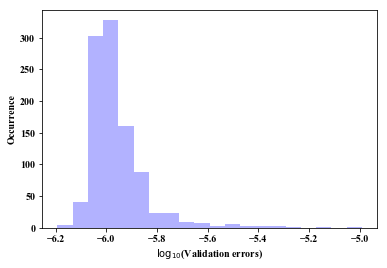

In [30]:
cv3.plot_monte_carlo_errors(axes='hist', n=20, color='b')  # color and marker options available

Let's next plot the validation errors from our Monte Carlo
K-fold cross-validation study above versus the samples at
which the validation error is recorded in each of the
(K=10)*(100) partitions.

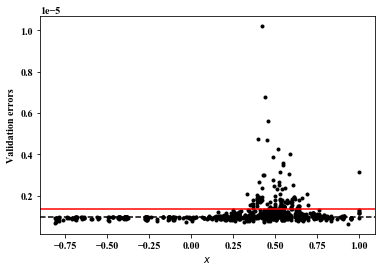

In [31]:
ax = cv3.plot_monte_carlo_errors(x=test.x, show=False)
ax.axhline(y=cv3._tol, color='k', linestyle='--');

# Mean of the mean validation errors greater than 1e-6
ax.axhline(y=np.mean(cv3.means_all_errors_ge_tol), color='r');

Note that the highest validation errors are concentrated
around the region of the full dataset that has the
most variation/highest features. This distribution can
be used to estimate the $x$-dependent interpolation error 
across the domain, which will be implemented in a future
release of `romSpline`.

We can get a global estimate of the interpolation error by computing the mean
over all the validation errors that were just computed. But we only use
those validation errors that are greater than or equal to the tolerance,
which is 1e-6 here. This is done because the reduced-order spline can
only guarantee interpolation errors of the original data set that are
smaller than the tolerance. So, if a cross-validation error is below
the tolerance than it shouldn't be incorporated as part of the final error
estimate. But those larger than the tolerance are useful errors for
quantifying this uncertainty.

Some basic stats for the distribution of validation errors is provided using
the `stats` method.

In [32]:
cv3.stats()
print("Cross-validation error estimate =", np.mean(cv3.means_all_errors_ge_tol))

Cross-validation error estimate = 1.3513897040504804e-06


Let's compute the "real" interpolation error by upsampling the test 
function and comparing its values to the first reduced-order spline
(called `spline`) we calculated at the beginning of this notebook. 
We can then compare the largest such error with the error estimate that came
from the Monte Carlo K-fold cross-validation study that we just performed
to see if it provides a useful approximate upper bound.

In [33]:
testUpsampled = romspline.TestData(num=100*len(test.x))
print("Max interpolation error on upsampled data =", \
    np.max( spline.test(testUpsampled.x, testUpsampled.y, verbose=False) ))

Max interpolation error on upsampled data = 1.012765522112602e-06


We see that the Monte Carlo K-fold cross-validation study gives a useful
global upper bound on the reduced-order spline interpolation error. We 
can expect that interpolating the `TestData` function at arbitrary samples
in [-1,1] would yield absolute differences no larger than the cross-validation
error estimate computed above.

## Estimating interpolation error for low-resolution data and the role of convergence

Let's look at a similar example where our test data set 
is undersampled to the point that the reduced-order spline
interpolant is not in a convergent regime for the default tolerance of
$10^{-6}$. 

First, let's generate the undersampled test data.

In [34]:
test2 = romspline.TestData(num=len(test.x)/4.)

Second, let's generate the reduced-order spline for a tolerance of 1e-6
using 5th degree polynomials (i.e., the default case).

In [35]:
spline2 = romspline.ReducedOrderSpline(test2.x, test2.y)

As expected, this interpolant is not convergent for this data set
and tolerance:

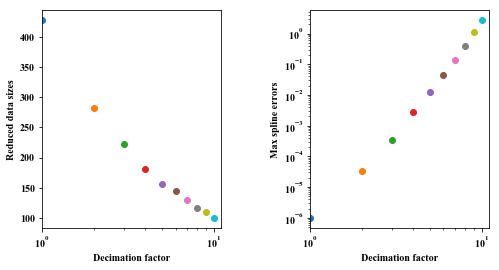

In [36]:
conv3 = romspline.Convergence()
conv3.make(test2.x, test2.y, levs=np.arange(1, 11))

# Show the sizes and max spline errors for each decimation case
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[8,4])
plt.subplots_adjust(wspace=0.5)
conv3.plot_sizes(ax=ax[0], show=False)
conv3.plot_Linfty_errors(ax=ax[1]);

What happens when we perform a Monte Carlo K-fold cross-validation 
study for this case where the reduced-order spline is not convergent?
Let's find out.

In [37]:
cv4 = romspline.CrossValidation()
cv4.MonteCarloKfold(test2.x, test2.y, 100, verbose=True)

Trials completed: 10
Trials completed: 20
Trials completed: 30
Trials completed: 40
Trials completed: 50
Trials completed: 60
Trials completed: 70
Trials completed: 80
Trials completed: 90
Trials completed: 100


Well, the validation errors tend to be relatively large,
especially in the region where the original data set has 
the strongest variations and features. Below is a plot showing
the validation errors as a function of $x$. You can see that
these are concentrated around the part of the data that varies
the strongest, namely, around $x=0.5$. Because the reduced-order
spline is not in a convergent regime then its interpolation
errors are relatively sensitive to the data the spline was trained on.

Mean of validation errors >= tolerance = 0.0004115989412691648
Reduced-order spline tolerance = 1e-06


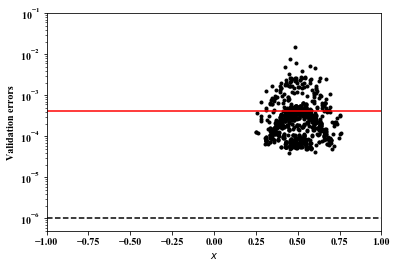

In [38]:
ax = cv4.plot_monte_carlo_errors(x=test2.x, axes='semilogy', show=False)

cv4.stats()  # Compute some basic statistics of the errors
print("Mean of validation errors >= tolerance =", np.mean(cv4.means_all_errors_ge_tol))
print("Reduced-order spline tolerance =", cv4._tol)
ax.axhline(y=np.mean(cv4._tol), linestyle='--', color='k')
ax.axhline(y=np.mean(cv4.means_all_errors_ge_tol), linestyle='-', color='r')

ax.set_xlim(-1,1)
ax.set_ylim(5e-7, 1e-1);

The "true" interpolation error can be estimated by sampling the 
 test function at a large number of samples and comparing those values
to the reduced-order spline's predictions at those same points.

In [39]:
xx2 = np.linspace(test2.x.min(), test2.x.max(), num=100*len(test2.x))
print("Max interpolation error on upsampled data =", np.max( spline2.test(xx2, test2.f(xx2)) ))

Max interpolation error on upsampled data = 1.1847841392409464e-06


Notice that the "true" maximum interpolation error is actually much lower 
than what is indicated by the mean of the validation errors (those greater than
or equal to the tolerance) from the
Monte Carlo K-fold cross-validation study. Therefore, if the data is 
undersampled and not convergent for the requested tolerance then 
cross-validation tools may indicate larger
interpolation errors for predicting new values than is actually the case.

If this occurs, one might instead specify a tolerance
for the greedy algorithm such that the resulting interpolant is in the convergent
regime. Then, the cross-validation errors will be more indicative of the expected
interpolation errors. 

For example, running the next few lines achieves this for our `test2` data.
First, we examine the convergence of greedy errors.

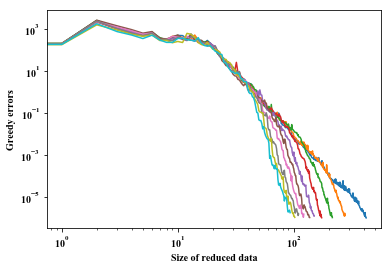

In [40]:
conv3.plot_greedy_errors(axes='loglog')

The blue, green, red, and cyan curves all seem to intersect near about 1e-2
so let's use that for the tolerance and build a new reduced-order spline.

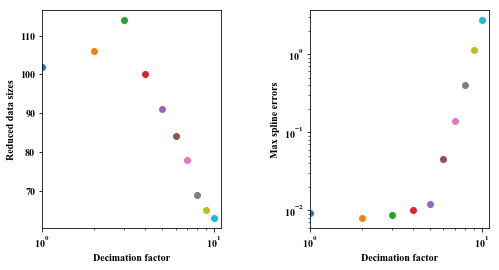

In [41]:
# New spline for new tolerance
spline3 = romspline.ReducedOrderSpline(test2.x, test2.y, tol=1e-2)

# Check that this new spline is convergent
conv4 = romspline.Convergence(tol=1e-2)
conv4.make(test2.x, test2.y, levs=np.arange(1, 11))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[8,4])
plt.subplots_adjust(wspace=0.5)
conv4.plot_sizes(ax=ax[0], show=False)
conv4.plot_Linfty_errors(ax=ax[1]);

Sure enough, this reduced-order spline is in a convergent regime.
Now we do a Monte Carlo K-fold cross-validation study to find
the mean of the validation errors that are greater than or equal
to the tolerance, which is 1e-2 here.

In [42]:
cv5 = romspline.CrossValidation(tol=1e-2)
cv5.MonteCarloKfold(test2.x, test2.y, 100, K=10, verbose=False)

cv5.stats()
print("Mean of mean validation errors =", np.mean(cv5.means_all_errors_ge_tol))
print("Reduced-order spline tolerance =", cv5._tol)
print("Max interpolation error on upsampled data =", np.max( spline3.test(xx2, test2.f(xx2)) ))

Mean of mean validation errors = 0.012356817039184552
Reduced-order spline tolerance = 0.01
Max interpolation error on upsampled data = 0.009287970630598608


When the reduced-order spline is convergent, the global
interpolation error estimates that come from Monte Carlo K-fold
cross-validation studies are more reliable and provide a reasonable upper bound on the
(global) interpolation error for predicting new values.